In [75]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools

# sklearn
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          plot_place=[0, 0, 0]):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.subplot(*plot_place)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [76]:
import pandas as pd

suicidal = pd.read_csv("PreparedDatasets/suicidal.csv")
non_suicidal = pd.read_csv("PreparedDatasets/non_suicidal.csv").head(1500)

data = suicidal.append(non_suicidal)

data = data.sample(frac=1)
data

/var/folders/nd/rxp2phv12xl4m1wk92ksqgxr0000gn/T/ipykernel_2299/3503685206.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = suicidal.append(non_suicidal)


,Unnamed: 0,text,class
1253,1587,конфетки мне уже три раза одну штучку передава...,0
501,624,"Найс Хорошо, что не ивентовый...",0
1441,1825,Вышла новая 4 серия 2 сезона!,0
478,599,"Ванильное овсяное молоко, мороженое и милки ве...",0
615,615,22. Шестой год апатии. Почти полное отсутствие...,1
...,...,...,...
234,234,Одна сплошная боль.Хочешь уменьшить - ее стане...,1
109,130,"У меня нет на карте 4 884 ¥ ,потому что у меня...",0
747,747,"27 января планировался суицид, все уже пригото...",1
1329,1689,"Не стерся,все хорошо.",0


In [77]:
from pymorphy3 import MorphAnalyzer
import nltk
from nltk.corpus import stopwords

# nltk.download('stopwords')

an = MorphAnalyzer(lang='ru')
stops = stopwords.words('russian')

def getClearSentences(sentences):
    return " ".join(str(s) + "" for s in (an.normal_forms(y)[0] for y in filter(lambda x: x not in stops, nltk.word_tokenize(str(sentences)))))

data['text'] = data['text'].apply(lambda x: getClearSentences(x))
corpus = data['text']
corpus

1253    конфетка раз один штучка передавать хвхазаза п...
501                          найса хорошо , ивентовый ...
1441                        выйти новый 4 серия 2 сезон !
478     ванильный овсяный молоко , мороженое милка вея...
615     22 . шестой год апатия . почти полный отсутств...
                              ...                        
234         один сплошной боль.хотеть уменьшить - стать .
109                             у карта 4 884 ¥ , карта .
747     27 январь планироваться суицид , приготовить ,...
1329                                     не стереться , .
345     просто переполнять самый чувство , понимать че...
Name: text, Length: 2499, dtype: object

In [78]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorized_data = vectorizer.fit_transform(corpus)
vectorized_data

<2499x9470 sparse matrix of type '<class 'numpy.int64'>'
	with 48142 stored elements in Compressed Sparse Row format>

In [101]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

classes_data = data['class'].apply(lambda x: int(x))

def confusionMatrices(estimator, classes = []):
    splits = 3
    kf = KFold(n_splits=splits)
    n = 1
    plt.figure(figsize=(20, 10))
    for train, test in kf.split(vectorized_data):
        estimator.fit(vectorized_data[train], classes_data.iloc[train].values.ravel())
        predicted = estimator.predict(vectorized_data[test])

        matrix = confusion_matrix(classes_data.iloc[test], predicted)
        plot_confusion_matrix(matrix, classes, plot_place=[splits, 1, n])
        n += 1

def crossScores(estimator):
    crossScoreAccuracy = cross_val_score(estimator, scoring='accuracy', X=vectorized_data, y=classes_data.tolist(), cv=3)
    crossScoreF = cross_val_score(estimator, scoring='f1', X=vectorized_data, y=classes_data.tolist(), cv=3)
    crossScoreRocAuc = cross_val_score(estimator, scoring='roc_auc', X=vectorized_data, y=classes_data.tolist(), cv=3)

    fig, axs = plt.subplots(3, figsize=(10, 20))
    
    axs[0].plot(crossScoreAccuracy)
    axs[0].set_title("Точность")
    axs[0].set(xlabel='Порядковый номер разбиения', ylabel='Значение метрики')

    axs[1].plot(crossScoreF)
    axs[1].set_title("F1")
    axs[1].set(xlabel='Порядковый номер разбиения', ylabel='Значение метрики')
    
    axs[2].plot(crossScoreRocAuc)
    axs[2].set_title("ROC AUC")
    axs[2].set(xlabel='Порядковый номер разбиения', ylabel='Значение метрики')


from sklearn.model_selection import GridSearchCV

def gridSearch(estimator, paramGrid):

    xTrain, xTest, yTrain, yTest = train_test_split(vectorized_data, classes_data, test_size=0.2)

    searchCV = GridSearchCV(estimator, param_grid=paramGrid, n_jobs=-1, scoring='f1', refit=False)
    searchCV.fit(xTrain, yTrain)
    print(searchCV.best_params_)
    searchCV.cv_results_

# Градиентный бустинг

In [102]:
from sklearn.ensemble import GradientBoostingClassifier

estimator = GradientBoostingClassifier()
gridSearch(estimator, paramGrid={'learning_rate': [0.1, 0.5, 1, 2], 'min_samples_split': [2, 3, 6], 'n_estimators': [20, 40, 60]})

{'learning_rate': 0.5, 'min_samples_split': 6, 'n_estimators': 60}


Confusion matrix, without normalization
[[478  27]
 [ 82 246]]
Confusion matrix, without normalization
[[443  28]
 [105 257]]
Confusion matrix, without normalization
[[486  37]
 [ 74 236]]


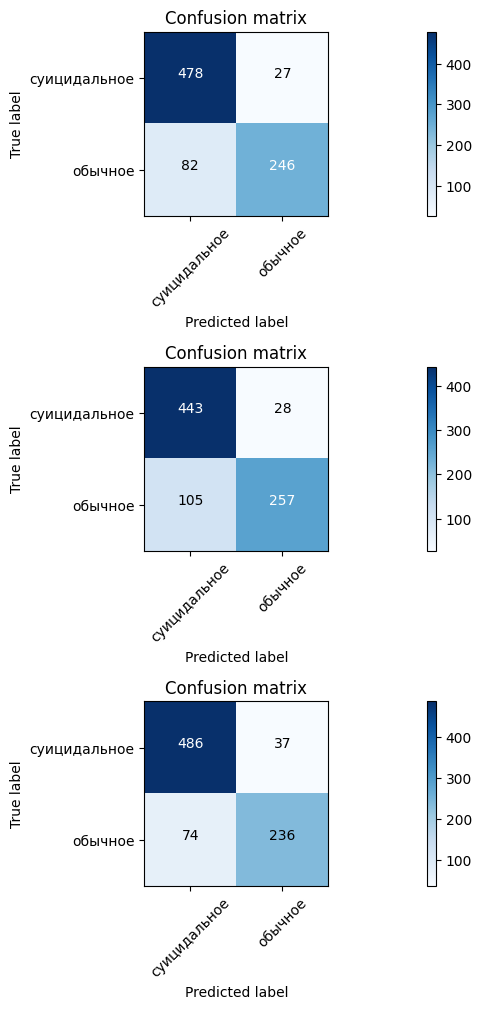

In [104]:
from sklearn.ensemble import GradientBoostingClassifier

estimator = GradientBoostingClassifier(learning_rate=0.5, min_samples_split=6, n_estimators=60)
confusionMatrices(estimator=estimator, classes=["суицидальное", "обычное"])

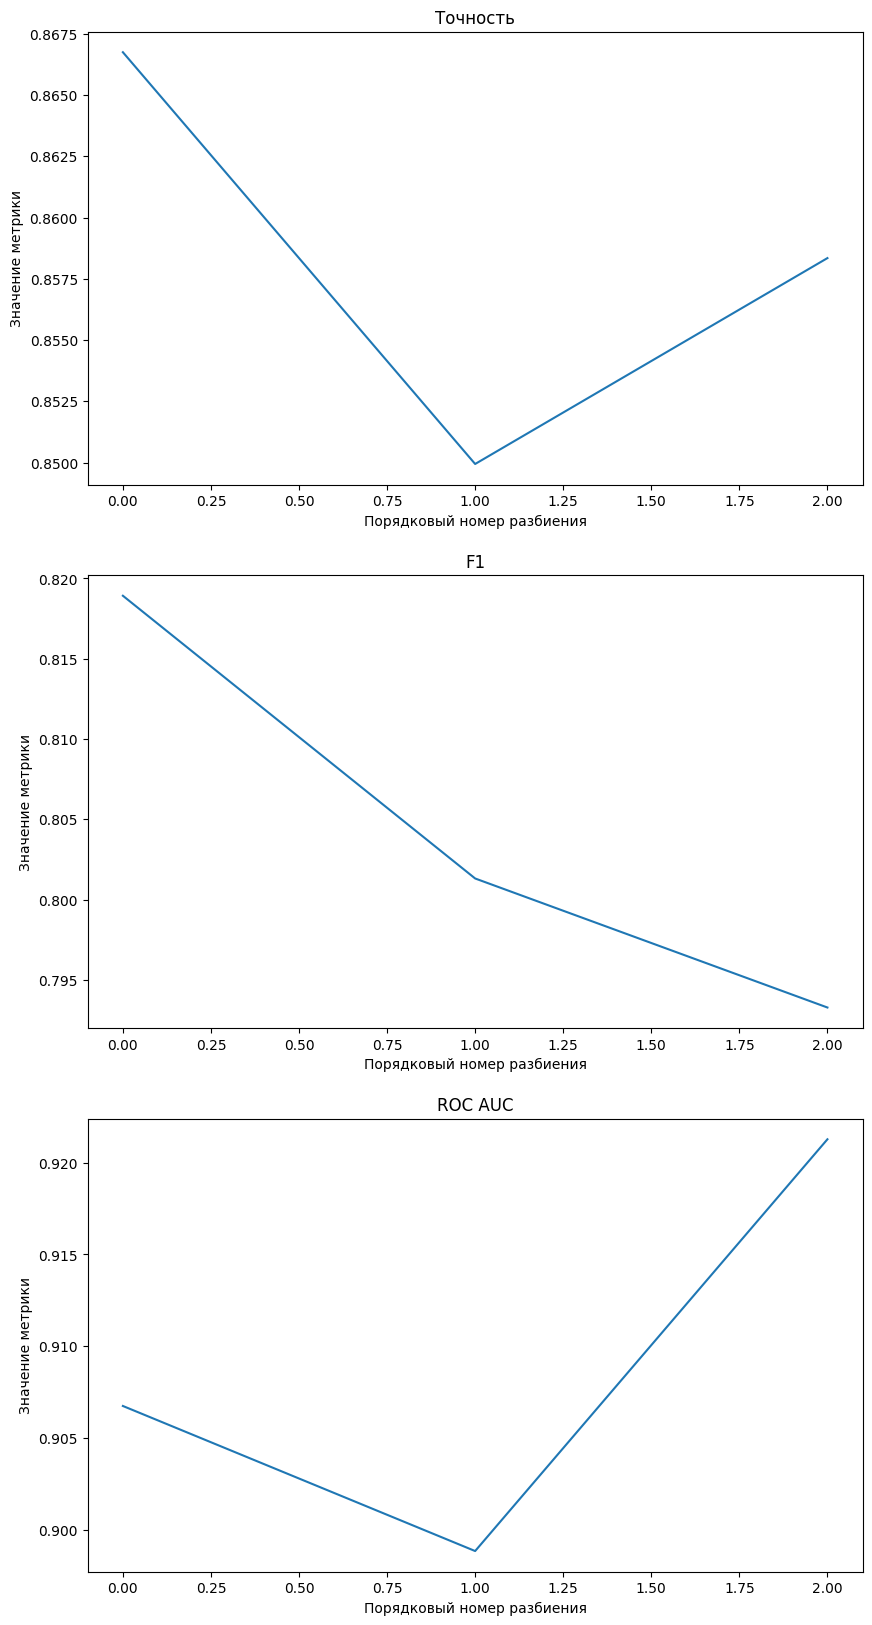

In [100]:
crossScores(estimator)

In [113]:
estimator.predict(vectorizer.transform([getClearSentences("Ща сдохну от смеха")]))

array([0])

# Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier()
gridSearch(estimator, paramGrid={'n_jobs': [-1],'n_estimators': [50, 100, 150], 'max_depth':[50, 100, 150], 'class_weight': [None, 'balanced', 'balanced_subsample'], 'max_features': ['sqrt', 'log2', None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]})

{'class_weight': None, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50, 'n_jobs': -1}


Confusion matrix, without normalization
[[488  19]
 [ 75 251]]
Confusion matrix, without normalization
[[468  35]
 [ 73 257]]
Confusion matrix, without normalization
[[456  33]
 [ 63 281]]


<Figure size 2000x1000 with 0 Axes>

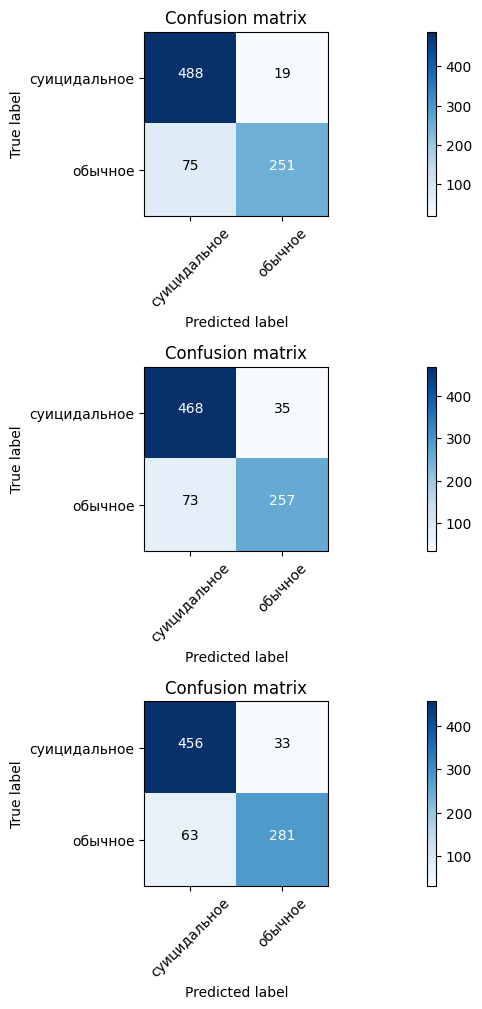

In [21]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(class_weight=None, max_depth=100, max_features='sqrt', min_samples_leaf=1, n_estimators=50, n_jobs=-1)
plt.figure(figsize=(20, 10))
confusionMatrices(estimator, ["суицидальное", "обычное"])

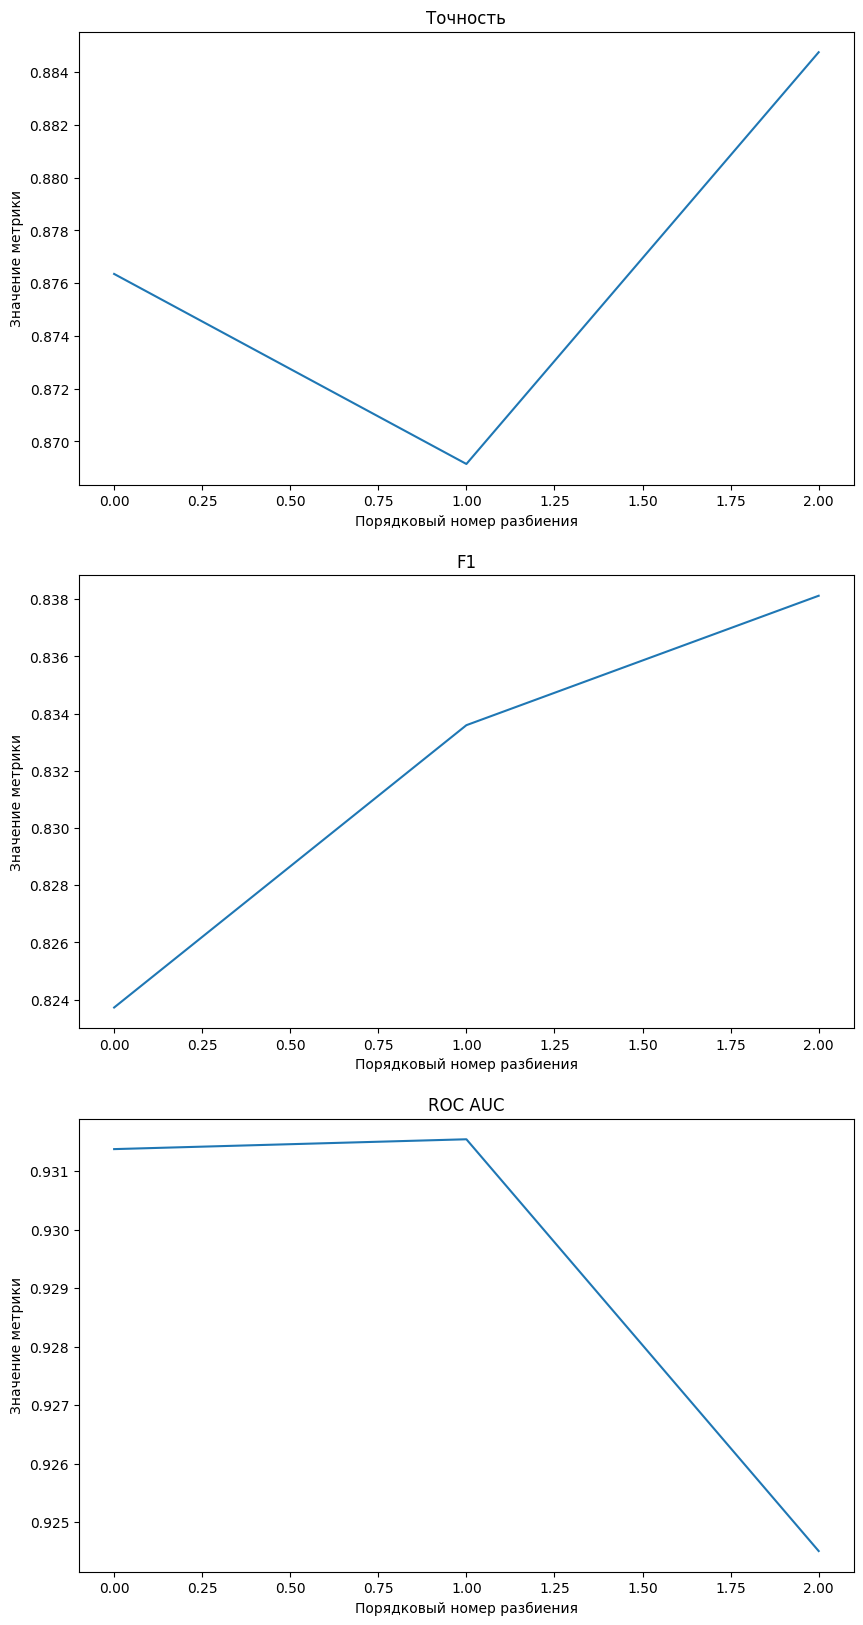

In [39]:
crossScores(estimator)

# SVC

In [ ]:
from sklearn.svm import SVC

estimator = SVC()
gridSearch(estimator, paramGrid={'C': [1.0, 2.0, 10.0, 100.0], 'degree': [3, 4, 6, 7], 'kernel': ['linear', 'poly', 'rbf']})

In [ ]:
estimator = SVC(C=1.0, degree=3, kernel='linear')
confusionMatrices(estimator, ["суицидальное", "обычное"])

In [ ]:
crossScores(estimator)

# KNN

In [87]:
from sklearn.neighbors import KNeighborsClassifier

estimator = KNeighborsClassifier()
print(gridSearch(estimator, paramGrid={'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance'], 'leaf_size': [20, 30, 40], 'p': [1, 2, 4], 'metric': ['euclidean', 'manhattan']}))

{'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
None


Confusion matrix, without normalization
[[470  35]
 [142 186]]
Confusion matrix, without normalization
[[449  22]
 [171 191]]
Confusion matrix, without normalization
[[507  16]
 [179 131]]


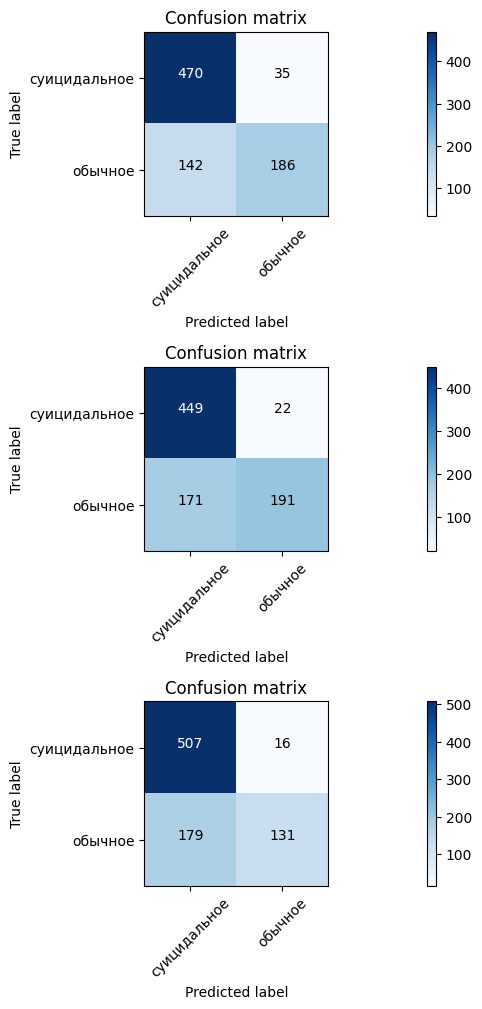

In [88]:
estimator = KNeighborsClassifier(n_neighbors=3, weights='distance', leaf_size=20, p=1, metric='euclidean')
confusionMatrices(estimator, ["суицидальное", "обычное"])

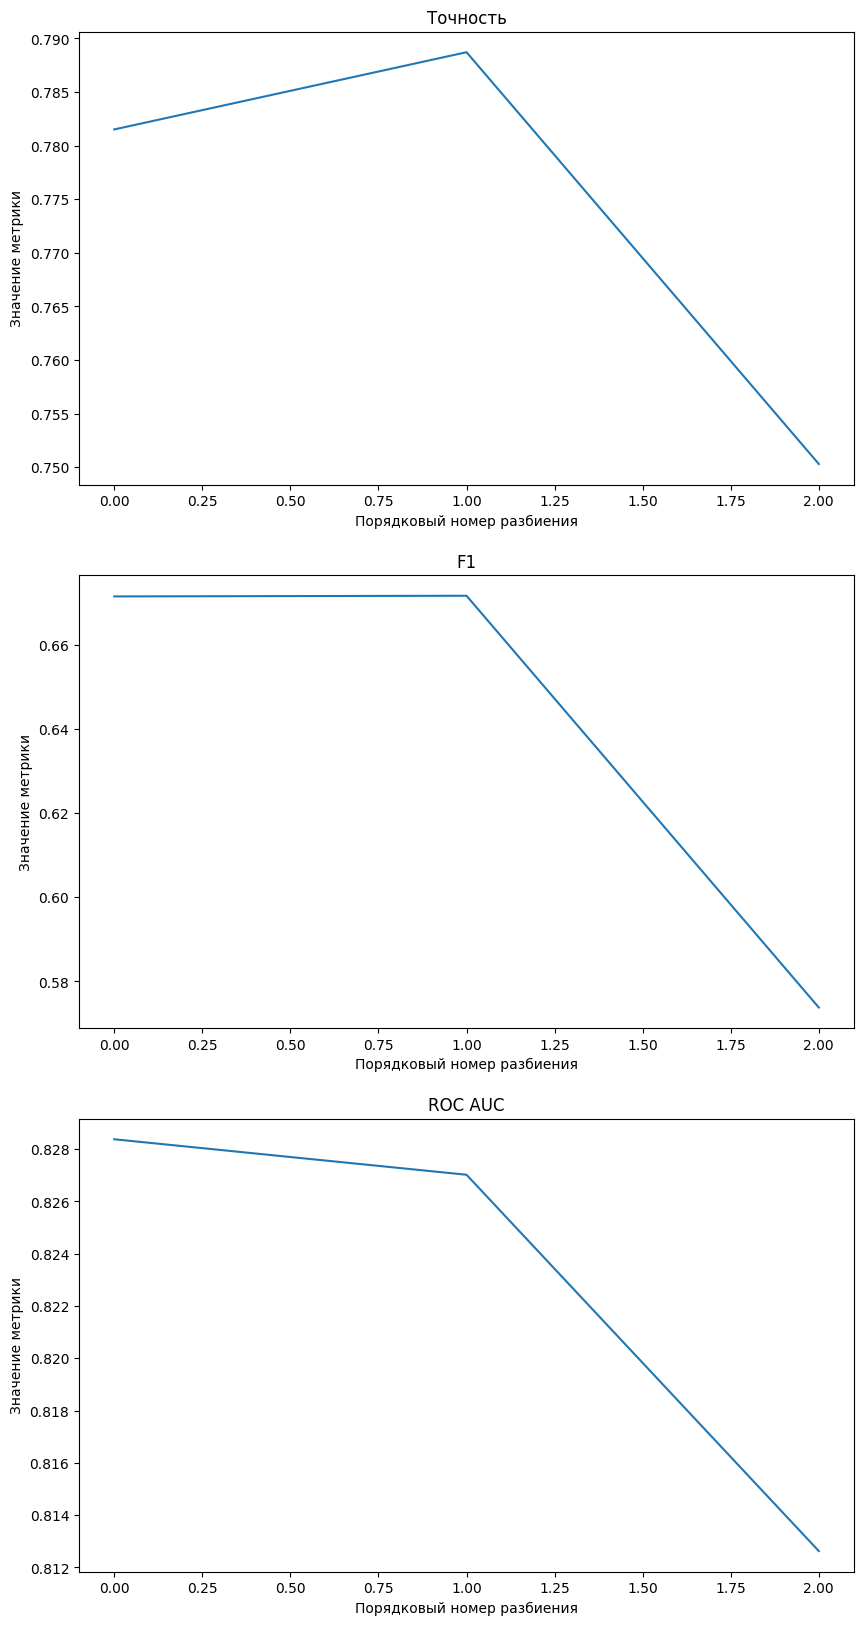

In [85]:
crossScores(estimator)

# Logistic Regression

In [69]:
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression()
gridSearch(estimator, paramGrid={'penalty': ['l2'], 'C': [2.1, 2.2, 2.3, 2.4], 'class_weight': [{0: 1, 1: 2}, {0: 2, 1: 1}, 'balanced'], 'solver': ['lbfgs', 'liblinear', 'newton-ct']})

{'C': 2.2, 'class_weight': {0: 2, 1: 1}, 'penalty': 'l2', 'solver': 'liblinear'}


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/opt/homebrew/lib/python3.11/site-packages

Confusion matrix, without normalization
[[458  42]
 [ 48 285]]
Confusion matrix, without normalization
[[474  40]
 [ 70 249]]
Confusion matrix, without normalization
[[445  40]
 [ 66 282]]


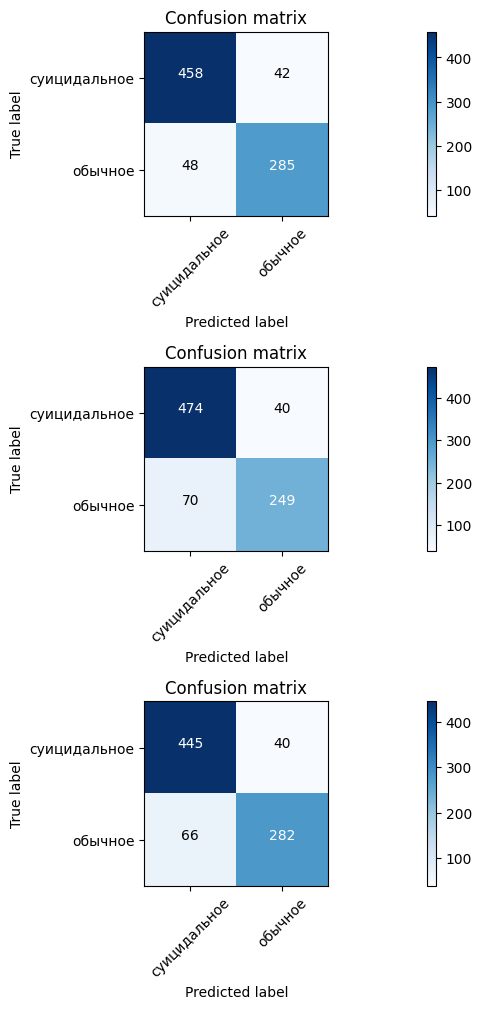

In [72]:
estimator = LogisticRegression(penalty='l2', C= 2.2, class_weight={0:1, 1:2}, solver='liblinear')
confusionMatrices(estimator, ["суицидальное", "обычное"])

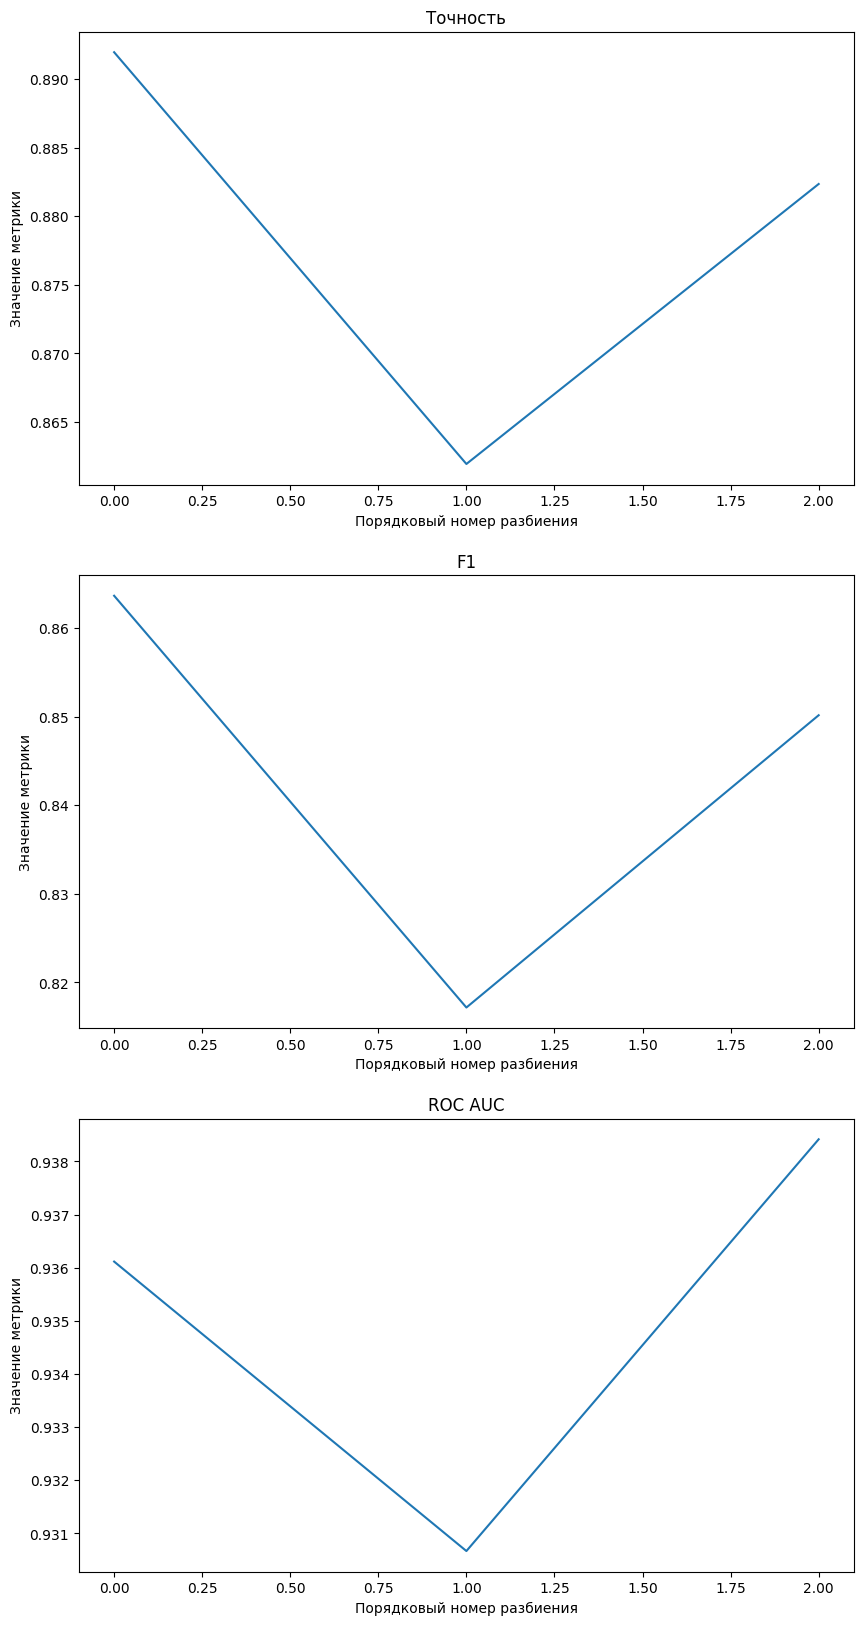

In [73]:
crossScores(estimator)

# Linear Resgression

In [96]:
from sklearn.linear_model import LinearRegression

estimator = LinearRegression()
gridSearch(estimator, paramGrid={'fit_intercept': [True, False], 'copy_X': [True], 'n_jobs': [-1]})

{'copy_X': True, 'fit_intercept': True, 'n_jobs': -1}


In [97]:
estimator = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=-1)
confusionMatrices(estimator, ["суицидальное", "обычное"])

ValueError: Classification metrics can't handle a mix of binary and continuous targets

<Figure size 2000x1000 with 0 Axes>